<a href="https://colab.research.google.com/github/GuySchnidrig/Guy-s-Google-Drive/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumor image classification with tensorflow
CAS project 2021  <br>
Philip Z. and Guy S.


In this project we implemented image classification (TensorFlow) on a novel histological dataset. We trained different models on training and validation data and then applied our models on new data. We acquired histological tiles by extracting them from pre-annotated images (self-generated), which we then split up into smaller tiles. Our result is a model which can annotate 4 different histological classes and print the respective percent confidence interval

In [2]:
# Import dependencies 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import itertools
import tensorflow_hub as hub
import tempfile
import subprocess
import time

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Your Data should be in your Google Drive
from google.colab import drive
drive.mount('/content/drive')


print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Mounted at /content/drive
TF version: 2.4.1
Hub version: 0.11.0
GPU is available


In [3]:
# Unzip data form Google Drive
!unzip -q "/content/drive/MyDrive/CAS/CAS Data project/Projekt 1.zip"


In [4]:
# Count the images

data_train= pathlib.Path('/content/Projekt 1/Training')
data_test= pathlib.Path('/content/Projekt 1/Testing') 
data_val= pathlib.Path('/content/Projekt 1/Validation')

image_count_train = len(list(data_train.glob('*/*.png')))
image_count_test = len(list(data_test.glob('*/*.png')))
image_count_val = len(list(data_val.glob('*/*.png')))

print("Training images:", image_count_train)
print("Testing images:", image_count_test)
print("Validation images:", image_count_val)

Training images: 3419
Testing images: 2133
Validation images: 1020


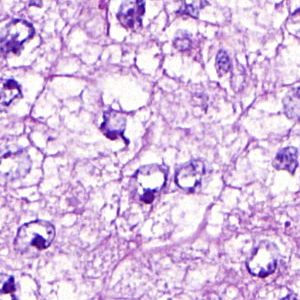

In [102]:
# Look at the first image of the training data (Immune)
cell = list(data_train.glob('Tumor_Train/*'))
PIL.Image.open(str(cell[0]))

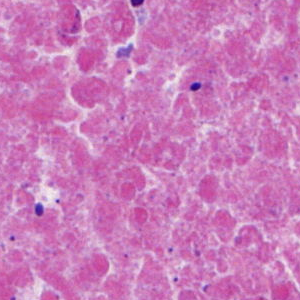

In [92]:
# Look at the first image of the test data (Necrosis)
cell = list(data_test.glob('Necrosis_Test/*'))
PIL.Image.open(str(cell[0]))

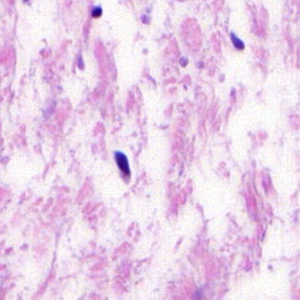

In [91]:
# Look at the first image if the validation data (Stroma)
cell = list(data_val.glob('Stroma_Val/*'))
PIL.Image.open(str(cell[0]))

# Model 1


In [8]:
# Define batchsize and image size
batch_size = 32
img_height = 180
img_width = 180

In [9]:
# Define trainig Set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3419 files belonging to 4 classes.


In [10]:
# Define validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_val,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1020 files belonging to 4 classes.


In [11]:
# Show classes
class_names = train_ds.class_names
print(class_names)

['Immune_Train', 'Necrosis_Train', 'Stroma_Train', 'Tumor_Train']


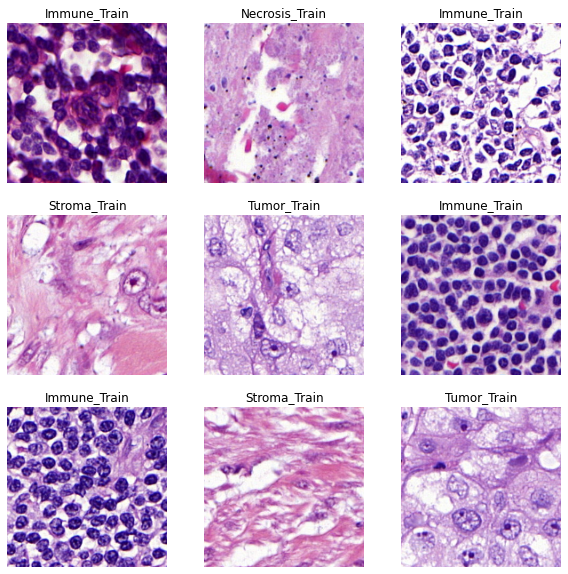

In [12]:
# Show some examples
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
# Look at image properties
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [14]:
# Recommened settings
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Implement normalization_layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))


# Notice the pixels values are now in `[0,1]`
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.005228918 1.0


In [16]:
# Apply some data augmentation
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [17]:
# Build our model with 4 classes
# One could try and experiemt with diffrent layers
num_classes = 4

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [18]:
# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)       

In [20]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
107/107 [==============================] - 39s 56ms/step - loss: 1.0087 - accuracy: 0.6491 - val_loss: 1.4042 - val_accuracy: 0.5549
Epoch 2/20
107/107 [==============================] - 2s 22ms/step - loss: 0.3778 - accuracy: 0.8308 - val_loss: 1.3604 - val_accuracy: 0.6961
Epoch 3/20
107/107 [==============================] - 2s 21ms/step - loss: 0.2224 - accuracy: 0.9092 - val_loss: 2.5974 - val_accuracy: 0.5039
Epoch 4/20
107/107 [==============================] - 2s 21ms/step - loss: 0.1893 - accuracy: 0.9210 - val_loss: 0.8249 - val_accuracy: 0.7324
Epoch 5/20
107/107 [==============================] - 2s 21ms/step - loss: 0.1432 - accuracy: 0.9459 - val_loss: 0.6120 - val_accuracy: 0.7471
Epoch 6/20
107/107 [==============================] - 2s 21ms/step - loss: 0.1509 - accuracy: 0.9361 - val_loss: 0.4648 - val_accuracy: 0.8853
Epoch 7/20
107/107 [==============================] - 2s 22ms/step - loss: 0.1573 - accuracy: 0.9396 - val_loss: 1.5693 - val_accuracy: 0.757

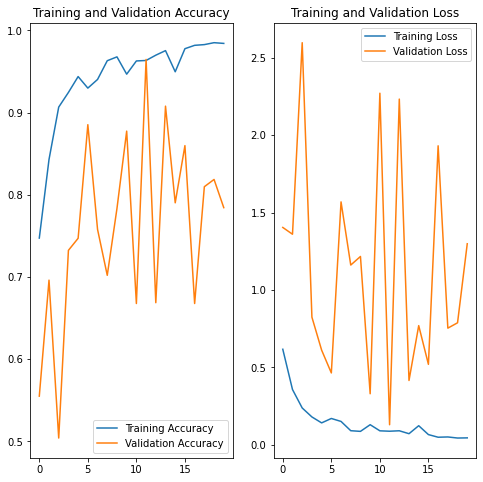

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model 2


In [22]:
# Unzip form Google Drive
!unzip -q "/content/drive/MyDrive/CAS/CAS Data project/Projekt 1.1 all.zip"

In [23]:
# Import Folders
data_all= pathlib.Path('/content/Projekt 1.1 all')

image_count_all = len(list(data_all.glob('*/*.png')))

print("Training images:", image_count_all)


Training images: 4672


In [24]:
# Model selection
# efficientnet_b3 for 300px images works best at the moment
# Research suggets resnet but somehow its not working anymore (on tf website)

model_name = "efficientnet_b3" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32

Selected model: efficientnet_b3 : https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1
Input size (300, 300)


In [25]:
# Create data sets and validation split

datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_all, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = True
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_all, subset="training", shuffle=True, **dataflow_kwargs)

Found 932 images belonging to 4 classes.
Found 3740 images belonging to 4 classes.


In [26]:
do_fine_tuning = True

print("Building model with", model_handle)
model_2 = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model_2.build((None,)+IMAGE_SIZE+(3,))
model_2.summary()

Building model with https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1536)              10783528  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________


In [27]:
model_2.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [28]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model_2.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
116/116 [==============================] - 162s 1s/step - loss: 0.9595 - accuracy: 0.7684 - val_loss: 0.7111 - val_accuracy: 0.9784
Epoch 2/5
116/116 [==============================] - 131s 1s/step - loss: 0.5912 - accuracy: 0.9880 - val_loss: 0.6402 - val_accuracy: 0.9828
Epoch 3/5
116/116 [==============================] - 131s 1s/step - loss: 0.5743 - accuracy: 0.9940 - val_loss: 0.5957 - val_accuracy: 0.9892
Epoch 4/5
116/116 [==============================] - 132s 1s/step - loss: 0.5725 - accuracy: 0.9922 - val_loss: 0.5821 - val_accuracy: 0.9903
Epoch 5/5
116/116 [==============================] - 131s 1s/step - loss: 0.5631 - accuracy: 0.9969 - val_loss: 0.5754 - val_accuracy: 0.9903


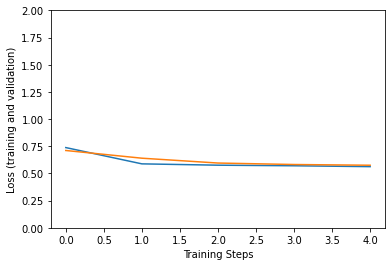

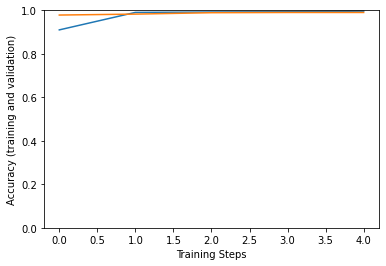

In [29]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

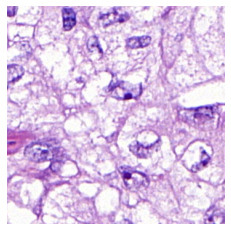

True label: Tumor
Predicted label: Tumor


In [111]:
# Test the model on validation data
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model_2.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

# Implementation on new data


In [31]:
# New data
data_path =  pathlib.Path("/content/drive/MyDrive/CAS/CAS Data project/Neu/")


In [32]:
# Rescale new images
datagen_kwargs_2 = dict(rescale=1./255)
dataflow_kwargs_2 = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen_2 = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)

train_datagen_2 = valid_datagen_2
train_generator = train_datagen_2.flow_from_directory(
    data_path, subset="training", shuffle=True, **dataflow_kwargs_2)


Found 12 images belonging to 1 classes.


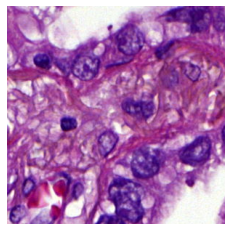

Tumor


In [158]:
# Try our model on the new images

x, y = next(train_generator)
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model_2.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)

if predicted_index == 3:
    print("Tumor")
else:
    print("No Tumor")


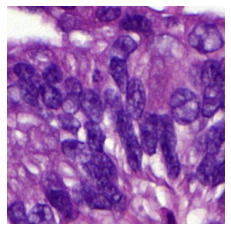

This image most likely belongs to the Tumor class (74.18 percent confidence)


In [138]:
# Improve it

x, y = next(train_generator)
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model_2.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
score = tf.nn.softmax(prediction_scores[0])

if predicted_index == 3:
    print(
        "This image most likely belongs to the {} class ({:.2f} percent confidence)"
        .format("Tumor", 100* np.max(score)))

elif predicted_index == 0:
       print(
        "This image most likely belongs to the {} class ({:.2f} percent confidence)"
        .format("Immune", 100* np.max(score)))

elif predicted_index == 2:
      print(
        "This image most likely belongs to the {} class ({:.2f} percent confidence)"
        .format("Stroma", 100* np.max(score)))

elif predicted_index== 1:
      print(
        "This image most likely belongs to the {} class ({:.2f} percent confidence)"
        .format("Necrosis", 100* np.max(score)))

else:
    print("Unknown")

In [35]:
# Save model to deploy with TF Serving or TF Lite (on mobile)
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model_2.save(export_path)

export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1615551270/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1615551270/assets


'/tmp/saved_models/1615551270'